# **Stock Market Analysis & Forecasting — GOOGL**

## **1. Introducción**

- **Contexto del problema**

    En el analiis de mercados financieros, los indicadores técnicos como  Golden and Death Cross son utilizados para identificar cambios de tendencia en el precio de los activos. Sin embargo esto solo responde al análisis y manipulación de los histórica, sin generar explicitamente escenarios futuros en el compoartamiento de los activos y su incertidumbre.
    Por otro lado el forecasting permite analizar patrones temporales y proyectar escenarios futuros apartir de supuestos estadisticos.

    Bajo esta perspectiva surge la necesidad de explorar ambos enfoques,con el fin de encontrar un punto complementario de ambos enfoques que permita abordar entendimiento y evaluó de escenarios futuros del activo seleccionado, en este caso el precio de las acciones de "GOOGL".

- **Objetivos del proyecto**

    Analizar el comportamiento histórico de la acción de Google (GOOGL) mediante indicadores de análisis técnico y modelos de forecasting, con el fin de evaluar cómo las señales Golden Cross y Death Cross pueden complementarse con proyecciones de series de tiempo para una mejor interpretación de tendencias.

## **Librerías**

In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import datetime as dt
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from prophet import Prophet
from scipy.stats import t


c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## **2. Obtención de datos**
**- Descarga de datos desde Yahoo Finance**

A continuación, procedemos a descargar los datos a través de la librería de Yahoo Finance. Con el fin de automatizar el proceso, definimos desde un inicio los horizontes de tiempo y las fechas a recolectar, así como los históricos definidos a 8 años, abarcando periodos importantes como la pandemia hasta la actualidad.
    
**- Descripción del dataset**

**Open (Precio de apertura):** Representa el primer precio al que se negoció la acción al inicio de la sesión bursátil.
Este valor incorpora la información y expectativas generadas fuera del horario de mercado (overnight).

**High (Precio máximo del día):** Indica el precio más alto alcanzado durante la sesión. Refleja niveles de resistencia y la intensidad de la presión compradora.

**Low (Precio mínimo del día)** Corresponde al precio más bajo al que se negoció la acción durante el día. Señala zonas de soporte y presión vendedora.

**Close (Precio de cierre):** Es el último precio negociado antes del cierre del mercado. Representa el consenso final del mercado para ese día.

**Adj Close (Precio de cierre ajustado):** Precio de cierre ajustado por eventos corporativos como dividendos, splits y recompras de acciones. Permite comparaciones consistentes a lo largo del tiempo.

**Volume (Volumen de negociación):** Número total de acciones intercambiadas durante la sesión. Es un indicador de liquidez y del interés del mercado en el activo.

**Ticker (Identificador del activo):** Símbolo bursátil que identifica al instrumento financiero. En este dataset corresponde a GOOGL, acción clase A de Alphabet Inc.

In [2]:
#Indicamos el activo a analizar
ticker = "GOOGL"

# Días de entrenamiento para Forecasting
n_train = 30

#Fechas de hostoricos a contemplar
fecha_inicio = "2018-01-01"
fecha_fin = pd.to_datetime("today")

#Extracción de los datos mediante Yahoo Finance
datos = yf.download(
    ticker,
    start=fecha_inicio,
    end=fecha_fin,
    interval="1d",
    auto_adjust=False,
    progress=False
)

In [3]:
# Agregamos el nombre de la accion como columna
datos["Ticker"]= ticker

# Datos con los que contamos
print('-'*50)
print("Cantidad de registros y columnas", datos.shape)
print('-'*50)

# Identificamos valores nulos 
print("Cantidad de nulos:")
display(datos.isna().sum())
print('-'*50)

# Evaluo de los datos obtenidos
print("Descripción estadística de los datos:")
display(datos.describe(percentiles=[.05,.25,.5,.75,.95]))

# Evaluo de los datos obtenidos
print('-'*50)
print("Muestra de los datos:")
datos.head(5)

--------------------------------------------------
Cantidad de registros y columnas (2037, 7)
--------------------------------------------------
Cantidad de nulos:


Price      Ticker
Adj Close  GOOGL     0
Close      GOOGL     0
High       GOOGL     0
Low        GOOGL     0
Open       GOOGL     0
Volume     GOOGL     0
Ticker               0
dtype: int64

--------------------------------------------------
Descripción estadística de los datos:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
count,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2.037000e+03
mean,117.231810,117.910161,119.205074,116.537815,117.845223,3.413416e+07
std,59.177881,59.193719,59.880143,58.440590,59.182350,1.539268e+07
min,48.864296,49.233501,50.605999,48.882999,49.216000,9.312000e+06
5%,53.639513,54.044798,54.661501,53.363898,54.051299,1.858776e+07
25%,64.519508,65.007004,65.497498,64.607498,64.928497,2.437030e+07
50%,110.651939,111.487999,112.940002,109.930000,111.306000,3.046780e+07
75%,145.104141,146.119995,147.535507,144.626999,146.080002,3.894800e+07
95%,240.298819,240.455997,242.457999,237.880005,240.242004,6.350152e+07


--------------------------------------------------
Muestra de los datos:


Price,Adj Close,Close,High,Low,Open,Volume,Ticker
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,
Date,,,,,,,
2018-01-02,53.258095,53.660500,53.799000,52.651001,52.651001,31766000,GOOGL
2018-01-03,54.166733,54.576000,54.805000,53.671501,53.696499,31318000,GOOGL
2018-01-04,54.377136,54.787998,55.203999,54.713001,54.854500,26052000,GOOGL
2018-01-05,55.098194,55.514500,55.679001,55.090000,55.172501,30250000,GOOGL
2018-01-08,55.292721,55.710499,55.958000,55.500000,55.549999,24644000,GOOGL


## **3. Limpieza y preparación**
**Formato de fechas:**
Se estandarizó el formato de las fechas y se transformó el índice temporal a tipo datetime, garantizando una correcta manipulación y alineación de la serie de tiempo para los análisis posteriores.

**Valores faltantes:**
Tras la inspección del conjunto de datos, no se identificaron valores faltantes, por lo que no fue necesario aplicar técnicas de imputación o eliminación de observaciones.

**Selección de variables:**
Se decidió trabajar principalmente con la variable de precio de cierre ajustado (Adjusted Close), dado que refleja el valor final del activo al cierre del mercado y considera eventos corporativos como dividendos y splits.
De manera complementaria, se incorporó la variable de volumen, la cual permite analizar la intensidad de la actividad del mercado y apoyar la interpretación de movimientos relevantes en el precio del activo.

In [4]:
datos.dtypes

Price      Ticker
Adj Close  GOOGL     float64
Close      GOOGL     float64
High       GOOGL     float64
Low        GOOGL     float64
Open       GOOGL     float64
Volume     GOOGL       int64
Ticker                   str
dtype: object

In [5]:
#Encotramos el tipo de dato 
print("Tipo de dato index: ", datos.index.dtype)
# nos aseguramos que tenga el tipo de dato fecha y que elimine zonas horarias
datos.index = pd.to_datetime(datos.index).tz_localize(None)
print("Tipo de dato index: ", datos.index.dtype)

#Finalmente limpiamos las columnas para quedarnos con un solo nivel
datos.columns = datos.columns.droplevel(1)

Tipo de dato index:  datetime64[s]
Tipo de dato index:  datetime64[s]


## **4. Análisis exploratorio (EDA)**
**Objetivo del EDA:**
Entender el comportamiento histórico del precio, su variabilidad y estructura temporal antes de aplicar indicadores técnicos y modelos de forecasting.


#### **- Evolución del precio**
Al analizar la evolución histórica del precio de la acción de Alphabet (GOOGL), se observa una tendencia de **crecimiento sostenido durante los últimos ocho años**. A pesar de la caída registrada durante la crisis sanitaria de 2020, el precio del activo mostró una recuperación acelerada, cerrando el mismo año en niveles superiores a los previos a dicha corrección.

**Durante 2021, la acción presentó un crecimiento marcado**, seguido de una **tendecia bajista en 2022**, periodo en el cual el precio experimentó una contracción significativa. Posteriormente, el activo retomó una tendencia positiva, mostrando una** recuperación progresiva y consolidando un nuevo tramo de crecimiento en los años posteriores**.

En conjunto, la serie evidencia una estructura típica de mercados financieros: una tendencia alcista de largo plazo interrumpida por episodios de alta volatilidad y correcciones temporales, lo cual justifica el uso de herramientas de análisis técnico y modelos de series de tiempo para su estudio.

<Axes: title={'center': 'Tendencia de acción GOOGL | Variable: Volume'}, xlabel='Date'>

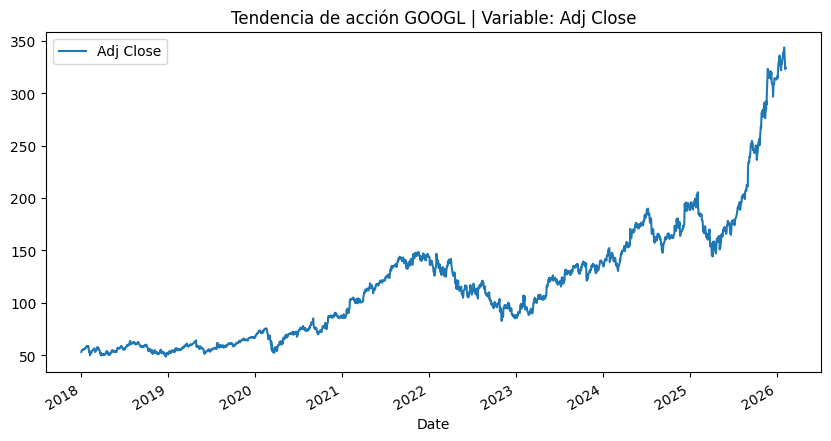

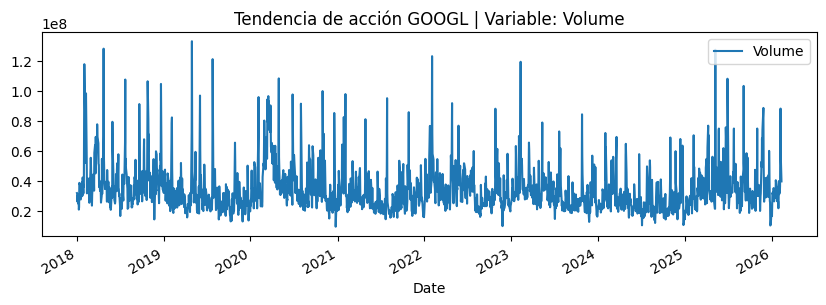

In [6]:
#Evolucion del precio a lo largo de los años 
variable ="Adj Close"
datos.plot(figsize=[10,5],
           title=f"Tendencia de acción {ticker} | Variable: {variable}",
           y= variable
           )
variable ="Volume"
datos.plot(figsize=[10,3],
           title=f"Tendencia de acción {ticker} | Variable: {variable}",
           y= variable
           )

#### **- Retornos temporales**
**Ventana 1 día**
El análisis de los retornos diarios muestra **una media cercana a cero**, con una **ligera inclinación hacia valores positivos**, comportamiento consistente con series financieras de media frecuencia de observación.

**Ventanas 30 a 360 días**
Al incrementar el horizonte temporal de cálculo, se observa una **mayor concentración de retornos positivos**, lo cual sugiere que la **tendencia alcista** identificada en el precio se vuelve más evidente al analizar ventanas de tiempo más amplias, reduciendo el efecto del ruido de corto plazo.

----------------------------------------------------------------------------------------------------
Comportamiento de los datos de Adj Close Var% vs 1 Días


count    2036.000000
mean        0.107672
std         1.944529
min       -11.630000
5%         -2.960000
25%        -0.850000
50%         0.140000
75%         1.122500
95%         3.005000
max        10.220000
Name: Adj Close, dtype: float64

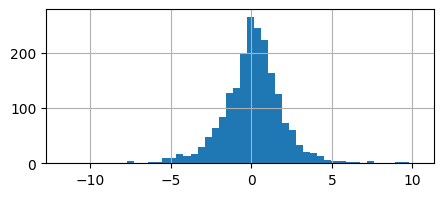

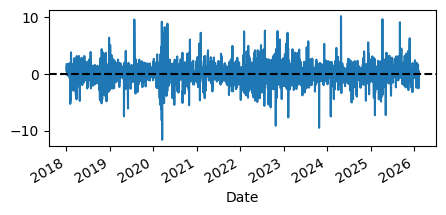

----------------------------------------------------------------------------------------------------
Comportamiento de los datos de Adj Close Var% vs 30 Días


count    2007.000000
mean        3.115361
std         9.269177
min       -28.730000
5%        -12.625000
25%        -2.790000
50%         4.050000
75%         8.920000
95%        17.812000
max        33.150000
Name: Adj Close, dtype: float64

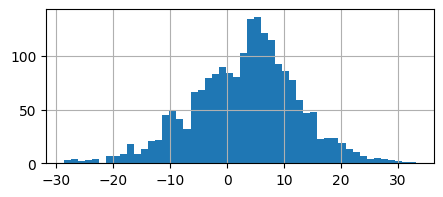

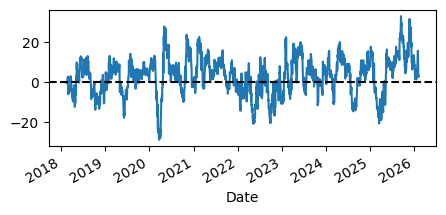

----------------------------------------------------------------------------------------------------
Comportamiento de los datos de Adj Close Var% vs 60 Días


count    1977.000000
mean        6.390496
std        14.069470
min       -30.300000
5%        -16.194000
25%        -4.370000
50%         7.230000
75%        16.030000
95%        29.770000
max        53.170000
Name: Adj Close, dtype: float64

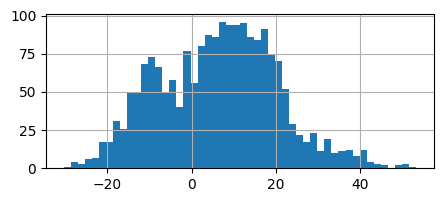

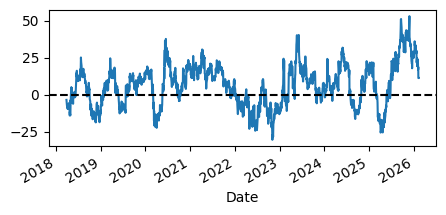

----------------------------------------------------------------------------------------------------
Comportamiento de los datos de Adj Close Var% vs 360 Días


count    1677.000000
mean       37.407126
std        38.663259
min       -36.450000
5%        -26.878000
25%        13.270000
50%        32.580000
75%        65.910000
95%       102.748000
max       169.570000
Name: Adj Close, dtype: float64

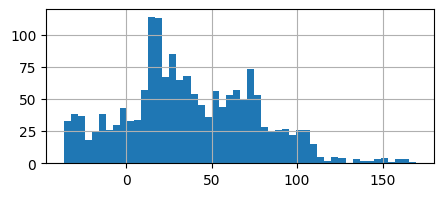

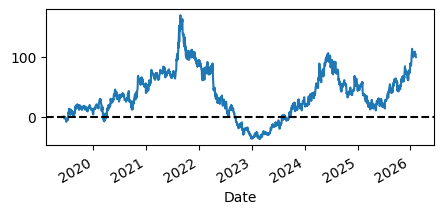

In [7]:
#Calculamos los cambios porcentuales vs DAYAGO
variable= "Adj Close"

for i in [1,30,60,360]:
    print("-"*100)
    print(f"Comportamiento de los datos de {variable} Var% vs {i} Días")
    returns = (datos[variable].pct_change(i)*100).round(2)
    display(returns.describe(percentiles=[.05,.25,.5,.75,.95]).T)
    returns.hist(figsize=[5,2], bins=50,)
    plt.show()
    returns.plot(figsize= (5,2))
    plt.axhline(0, color='black', linestyle='--')
    plt.show()

#### **- Volatilidad** 

Se observan periodos con **incrementos significativos en la volatilidad**, seguidos por intervalos de relativa estabilidad, lo que sugiere la presencia de clustering de volatilidad característico de series financieras.

Este comportamiento indica que la variabilidad de los retornos no es constante en el tiempo, evidenciando un patrón de **heterocedasticidad**. Dicha observación se confirma tanto de forma visual como mediante la aplicación de **la prueba ARCH**, la cual respalda estadísticamente la presencia de heterocedasticidad en los datos.
Al aplicar estos mismos criterios para el caso de los retornos díarios apreciamos una reducción en la dispersión de la volatilidad de los datos, incluso sin poderse confirmar heterocedasticidad a través de la prueba ARCH.

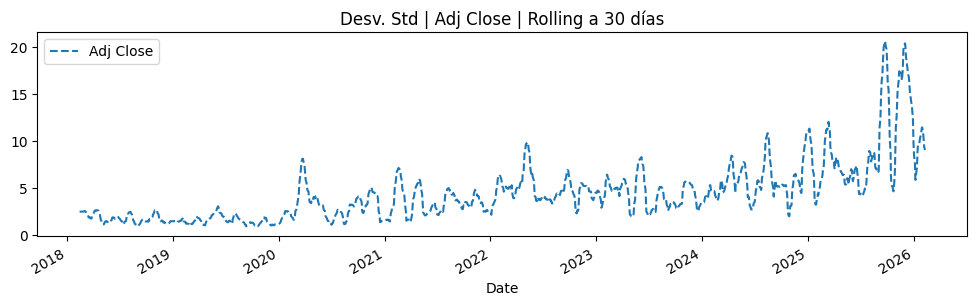

 >> P-Value Arch:  0.0


In [8]:
# Indicamos los días a considerar para la desviación estandar
roll = 30
#Graficamos los datos 
datos[variable].rolling(roll).std().plot(figsize = [12,3], title=f"Desv. Std | {variable} | Rolling a {roll} días", style="--")
plt.legend()
plt.show()

# Importamos la prueba de arch la cual evalua la hipotesis nula evalua la existencia de heterocedasticidad
arch_test = het_arch(datos[variable])

# p-value Resultante de la Hipotesis Nula
print( " >> P-Value Arch: ",arch_test[1]) 

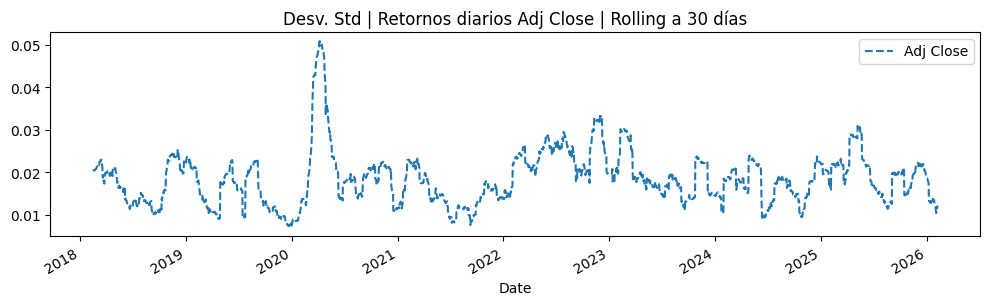

 >> P-Value Arch:  5.501635483689164e-20


In [9]:
#Calculamos los cambios porcentuales vs DAYAGO
variable= "Adj Close"

returns = np.log(datos[variable] / datos[variable].shift(1))
returns = returns.dropna()
returns.rolling(roll).std().plot(figsize = [12,3], title=f"Desv. Std | Retornos diarios {variable} | Rolling a {roll} días", style="--")
plt.legend()
plt.show()

# Importamos la prueba de arch la cual evalua la hipotesis nula evalua la existencia de heterocedasticidad
arch_test = het_arch(returns)

# p-value Resultante de la Hipotesis Nula
print( " >> P-Value Arch: ",arch_test[1]) 

#### **- Tendencias**
A partir del análisis de la media móvil de largo plazo, se identifican **cuatro cambios relevantes de tendencia** a lo largo del periodo analizado. No obstante, el comportamiento general del precio ha sido predominantemente alcista, lo cual es consistente con lo observado previamente en el análisis de retornos diarios.

En el caso de la **media móvil de corto plazo**, se observan múltiples cambios de dirección, reflejando una mayor sensibilidad a movimientos de corto plazo. **Aun así, los periodos alcistas resultan dominantes en la mayor parte de la serie**, con la excepción del intervalo comprendido entre 2022 y 2023, donde la acción presentó su fase de contracción más pronunciada.

En el periodo más reciente, el comportamiento del precio sugiere una tendencia de crecimiento, destacando un incremento aproximado del 90 % al comparar el mínimo observado en 2025 con el valor actual del activo.

In [10]:
#Definimos una función para calcular las medias móviles
def simple_moving_average(precio, data_window=20):
  return precio.rolling(window=data_window).mean()

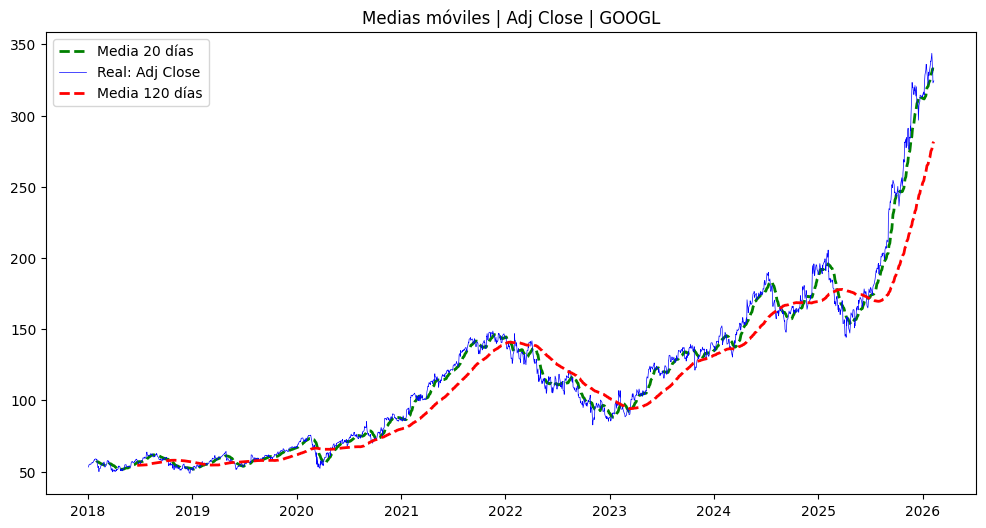

In [11]:
corta = 20
larga = 120
#Calculamos las medias larga y corta para entneder el comportamiento 
media_corta = simple_moving_average(datos[variable], corta)
media_larga = simple_moving_average(datos[variable], larga)

#Graficamos para que visualizar las tendencias 
plt.figure(figsize=(12,6))

plt.plot(media_corta, color='green', label=f'Media {corta} días',linestyle= "--", linewidth= 2)
plt.plot(datos[variable], color='blue', label=f'Real: {variable}', linestyle= "-", linewidth= 0.5)
plt.plot(media_larga, color='red', label=f'Media {larga} días', linestyle= "--", linewidth= 2)

plt.title(f"Medias móviles | {variable} | {ticker}")
plt.legend()
plt.show()

## **5. Indicadores técnicos (Golden Cross y Death Cross)**
Un **Golden Cross** es cuando una media movil **corta cruza a la alza** a una media móvil larga, esto se suele interpetrar como una señal alsista para el activo.

Caso contrario con un **Death Cross**, donde la media móvil c**orta atraviesa a la media móvil larga a la baja**, lo cúal se asocia a comportamientos de correcciones o tendencia bajista.

En la visualización se destacan los puntos donde ocurren los cruces entre medias móviles.Se observa que las señales de **Golden Cross** suelen aparecer tras periodos de consolidación o corrección, mientras que los Death Cross tienden a coincidir con fases de alta volatilidad o cambios macroeconómicos relevantes.

Este comportamiento refuerza la utilidad de las medias móviles como herramientas de análisis de tendencia, aunque se reconoce la existencia de señales tardías (lagging indicators).

In [12]:
# definimos la función que identifica los cruces de tendnecias 
def golden_death_crosses(precio, medias=(20,50), plt=False):
    
    #En funcion del tipo de media que queremos usar lo calcularemos
    if medias[0]>medias[1]:
      raise ValueError("La primera media debe ser menor que la segunda")

    ma_corta=simple_moving_average(precio, medias[0])
    ma_corta =ma_corta[~np.isnan(ma_corta)]
    ma_larga=simple_moving_average(precio, medias[1])
    ma_larga =ma_larga[~np.isnan(ma_larga)]

    # Seleccionamos los limites con medias moviles en las series cortas y largas (Eliminando los na de las medias largas)
    fechas_ma_corta=ma_corta.index
    fechas_ma_larga=ma_larga.index
    
    mask = ((fechas_ma_corta>fechas_ma_larga[0])&(fechas_ma_corta<=fechas_ma_larga[-1]))
    ma_corta = ma_corta.loc[mask]

    # Identificamos los golden ----------------------------------
    golden_crosses=[]
    for i_sma in range(1, len(ma_corta)-1):
        # Evalua si la media corta fue <(menor) a la a larga y posteriormente fue >(mayor) por dos peridos consecutivos vs el periodo a evaluar
        if ma_corta.iloc[i_sma-1] < ma_larga.iloc[i_sma-1] and ma_corta.iloc[i_sma] > ma_larga.iloc[i_sma] and ma_corta.iloc[i_sma+1] > ma_larga.iloc[i_sma]:
            golden_crosses.append(i_sma)
    
    # Identificamos los death ----------------------------------
    death_crosses=[]
    for i_sma in range(1, len(ma_corta)-1):
        # Evalua si la media corta fue >(mayor) a la a larga y posteriormente fue <(menor) por dos peridos consecutivos vs el periodo a evaluar
        if ma_corta.iloc[i_sma-1]>ma_larga.iloc[i_sma-1] and ma_corta.iloc[i_sma]<ma_larga.iloc[i_sma] and ma_corta.iloc[i_sma+1]<ma_larga.iloc[i_sma+1]:
            death_crosses.append(i_sma)

        #Grafica de los cruces de la muerte y dorados en la grafica tendnecial
    
    dicc = {'fecha':[], 'valor':[], 'fecha_compra/venta':[], 'valor_compra':[], 'tipo':[]}

    # Golden Cross
    for i_gc in golden_crosses:
        fecha = fechas_ma_larga[i_gc]
        valor = ma_larga.loc[fecha]
        fecha_2 = fechas_ma_larga[i_gc+1]
        valor_2 = ma_larga.loc[fecha_2]

        dicc['fecha'].append(fecha)
        dicc['valor'].append(valor)
        dicc['tipo'].append('Golden Cross')
        dicc['fecha_compra/venta'].append(fecha_2)
        dicc['valor_compra'].append(valor_2)

        if (plt != False):
            plt.plot(fecha, valor,"^",color="black",markersize=18, markerfacecolor="#00ff00")

    # Death Cross
    for i_dc in death_crosses:
        fecha = fechas_ma_larga[i_dc]
        valor = ma_larga.loc[fecha]
        fecha_2 = fechas_ma_larga[i_dc+1]
        valor_2 = ma_larga.loc[fecha_2]

        dicc['fecha'].append(fecha)
        dicc['valor'].append(valor)
        dicc['tipo'].append('Death Cross')
        dicc['fecha_compra/venta'].append(fecha_2)
        dicc['valor_compra'].append(valor_2)

        if (plt != False):
            plt.plot(fecha, valor,"v",color="black",markersize=18, markerfacecolor="#ff0000")

    if (plt != False):

        # Grafica de medias moviles largas y cortas
        plt.plot(ma_corta,
                color='green', linewidth=2, linestyle='--') 
        plt.plot(ma_larga,
                color='red', linewidth=2, linestyle='--') 
        plt.legend() 

    dicc = pd.DataFrame(dicc)
    dicc.sort_values(by="fecha", inplace=True)
    dicc.set_index('fecha', inplace=True)
    return dicc

In [13]:
def graficar_precio_volumen_activo(datos_actualizados, activo, medias_=(5,90), variable ="Aj. Close"):
    """
    Grafica el precio y el volumen de un activo específico con medias móviles y segmentación por mes y año.

    Parámetros:
        - datos_actualizados (DataFrame): Datos con columnas 'Ticker', 'Date', 'Close', 'Volume'.
        - activo (str): El ticker del activo a graficar.
    """
    print("")
    print("-"*100)
    print("Activo: ",activo)
    print("-"*100)
    print("")
    datos = datos_actualizados[datos_actualizados["Ticker"] == activo].copy()

    precio = datos[variable]
    volumen = datos["Volume"]

    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8, 3], 'hspace': 0.3}, figsize=(18, 8))

    a0.plot(datos.index, datos[variable], label=f'{variable}',color='blue')
    a0.set_title(f" ||| {activo} |||  Precio + Medias Moviles", 
                    fontsize=12, 
                    #color="blue", 
                    fontweight="bold")
    
    a0.grid()
    a1.plot(volumen, 
            color="blue", 
            linewidth=1)
    a1.set_title("Volumen", fontsize=12, 
                    #olor="blue", 
                    fontweight="bold")
 
    a1.grid()
    a0.legend(ncol=4, fontsize=6)

    golden_death_crosses(precio, plt= a0, medias=medias_)



    plt.xticks(rotation=45, ha='right')
    plt.show()


----------------------------------------------------------------------------------------------------
Activo:  GOOGL
----------------------------------------------------------------------------------------------------



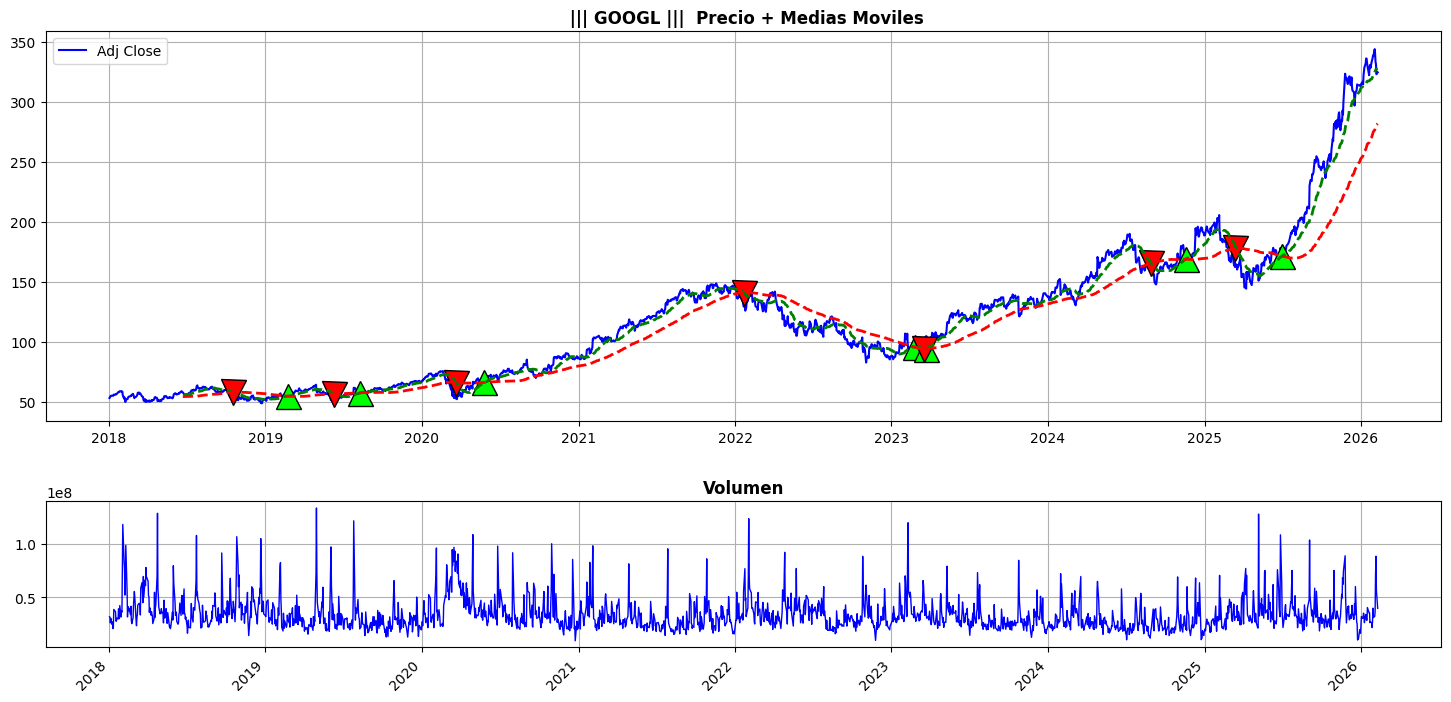

In [14]:
#Graficamos los indicadotes de los Golden and Death Cross 
graficar_precio_volumen_activo(datos, ticker, medias_=(30,120), variable = variable)

#### **-Interpretación de los indicadores**
Finalmente observamos el resultado de los cruces y los retornos que se hubieran gneerado a partir de la compra y venta en los indicadores obtenidos esto para entender los resultados a obtener según estos indicadores.
Como se aprecia en su mayoria se tiene comportamientos favorables con excepción de los 

In [15]:
print('-'*100)
print( "Periodos identificados como Goden and Death Cross")
print('-'*100)
golden_death = golden_death_crosses(datos[variable], medias=(30,120))
display(golden_death)

#Variaciones obtenidas al comprar en un Golden Cross y vender en un Death Cross

print('-'*100)
print( "Rendimientos generados al vender en la ciclicidad obtenida en indicadores Death Cross vs Último indicador")
print('-'*100)
golden_death['var%'] = golden_death['valor_compra'].pct_change().round(4)*100
golden_death[golden_death['tipo']=='Death Cross']

----------------------------------------------------------------------------------------------------
Periodos identificados como Goden and Death Cross
----------------------------------------------------------------------------------------------------


,valor,fecha_compra/venta,valor_compra,tipo
fecha,,,,
2018-10-17,57.903535,2018-10-18,57.936341,Death Cross
2019-02-22,54.840995,2019-02-25,54.784294,Golden Cross
2019-06-10,56.569246,2019-06-11,56.592152,Death Cross
2019-08-09,57.611392,2019-08-12,57.633686,Golden Cross
2020-03-20,66.144063,2020-03-23,66.074997,Death Cross
2020-05-26,66.202467,2020-05-27,66.254383,Golden Cross
2022-01-21,140.821398,2022-01-24,140.781483,Death Cross
2023-02-24,95.612165,2023-02-27,95.463455,Golden Cross
2023-03-17,94.238048,2023-03-20,94.263274,Death Cross


----------------------------------------------------------------------------------------------------
Rendimientos generados al vender en la ciclicidad obtenida en indicadores Death Cross vs Último indicador
----------------------------------------------------------------------------------------------------


,valor,fecha_compra/venta,valor_compra,tipo,var%
fecha,,,,,
2018-10-17,57.903535,2018-10-18,57.936341,Death Cross,NaN
2019-06-10,56.569246,2019-06-11,56.592152,Death Cross,3.30
2020-03-20,66.144063,2020-03-23,66.074997,Death Cross,14.65
2022-01-21,140.821398,2022-01-24,140.781483,Death Cross,112.49
2023-03-17,94.238048,2023-03-20,94.263274,Death Cross,-1.26
2024-08-28,165.893232,2024-08-29,166.112870,Death Cross,75.78
2025-03-14,177.814888,2025-03-17,177.823824,Death Cross,5.33


## **6. Modelado y forecasting**
**Objetivo general:**
Estimar el comportamiento futuro del activo bajo distintos horizontes temporales, integrando información histórica del precio y complementando con las señales técnicas previamente identificadas.

Se optó por **modelar retornos logarítmicos** en lugar del precio directamente, ya que presentan mayor estabilidad estadística, reducen problemas de no estacionariedad y permiten una mejor interpretación del riesgo.

El **horizonte de 30 días** naturales permite evaluar escenarios de corto–mediano plazo posteriores a las señales técnicas identificadas.


In [16]:
def graficar_acf_pacf_dickey( returns,lags_ = (300,40)):
    # Analizamos y graficamos la Autocorrelación de los  lags 
    fig, ax = plt.subplots(1, 2, figsize=(14,5))

    # Con ACF buscamos determinar MA(q) 
    plot_acf(returns, lags=lags_[0], ax=ax[0])
    ax[0].set_title("ACF - Retornos logarítmicos")

    #Con PACF Determinamos 
    plot_pacf(returns, lags=lags_[1], ax=ax[1], method='ywm')
    ax[1].set_title("PACF - Retornos logarítmicos")
    plt.show()

    # Buscamos aplicar la prueba de Dickey Fuller para comprobar que la serie es estacionaria
    adf = adfuller(returns)
    print(f"dickey Fuller p-value: {adf[1]:.8f}")


def graf_forecast_vs_real( train, test, forecast_arima, variable, datos, tipo_estimacion,line0 =False):
    # Graficamos los resultados para poder compararlos 
    fig, (a0, a1) = plt.subplots(nrows= 2, ncols=1, figsize=(12,8), gridspec_kw ={ 'height_ratios':[3,1], 'hspace': 0.3})
    #plt.figure(figsize=(12,5))

    a0.plot(train[train.index > '2023-01-01'], label= "Datos de entrenamiento", color= "blue", )
    a0.plot(test, label= "Datos de prueba", color= "green")
    a0.plot(test.index, forecast_arima, label='Forecast',  color= "red",linestyle='--')
    if line0 == True:
        a0.axhline(0, color='black', linestyle='--')
    a0.set_title(f'{tipo_estimacion} gráfica | {variable}')
    a0.legend()

    # plt.figure(figsize=(12,5))
    a1.plot(datos[datos.index > '2023-01-01'][variable], label= "Datos de entrenamiento", color= "blue")
    #a1.plot(test.index, price_forecast, label='Forecast',  color= "red",linestyle='--')
    a1.set_title(f'Gráfica {variable}', )
    a1.legend()
    plt.show()


#### **Modelo 1: ARIMA sobre log precios**

Se empleó un modelo ARIMA sobre los precios en escala logarítmica con el objetivo de estabilizar la varianza y trabajar sobre una dinámica multiplicativa del activo. No obstante, a pesar de la transformación, la serie no presenta estacionariedad, lo cual se confirma tanto visualmente como mediante pruebas estadísticas.

El análisis de la función de autocorrelación (ACF) muestra un decaimiento lento y progresivo, característico de series no estacionarias, sin un punto de corte claro que permita identificar un componente de medias móviles. Por su parte, la función de autocorrelación parcial (PACF) revela la presencia de pocos rezagos significativos, sugiriendo una estructura autoregresiva limitada.

Con base en estos hallazgos, se optó por un modelo ARIMA(2,1,0), incorporando una diferenciación para inducir estacionariedad y un término de medias móviles como aproximación a la dependencia temporal residual. Sin embargo, el comportamiento observado en la fase de forecasting muestra una trayectoria prácticamente plana, resultado coherente con las propiedades estadísticas de la serie y con la limitada capacidad del modelo para capturar dinámicas complejas en precios logarítmicos.

Este resultado refuerza la necesidad de explorar enfoques alternativos, tales como el modelado sobre retornos logarítmicos o el uso de modelos diseñados específicamente para capturar la dinámica de la volatilidad.

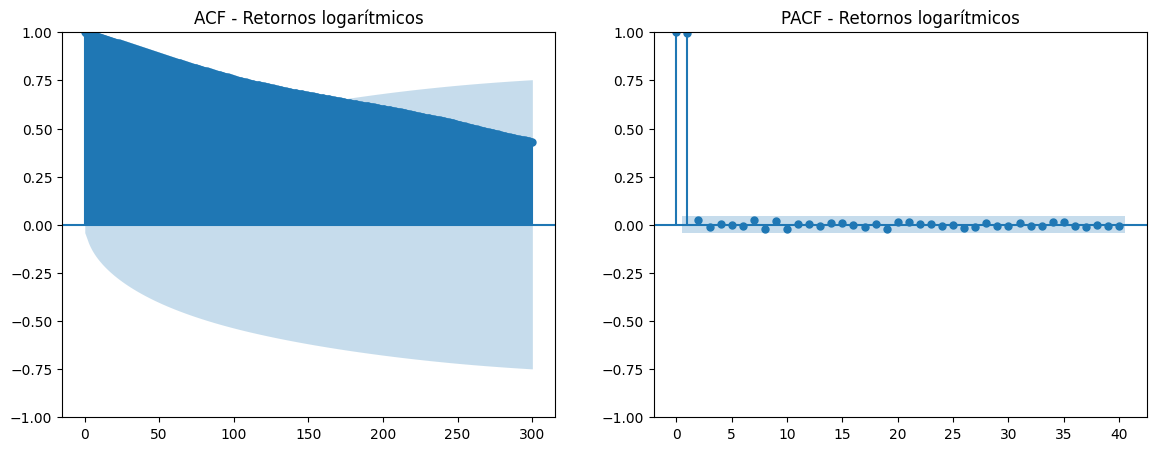

dickey Fuller p-value: 0.98102691


In [17]:
# Preparamos la serie a emplear
returns = np.log( datos[variable ])

#Definimos una frecuencia de Business Days
returns = returns.asfreq('B') 
# Eliminamos los valores NaN
returns = returns.dropna()

graficar_acf_pacf_dickey( returns,lags_ = (300,40))

In [18]:
# Dividimos nuestro conjunto de datos en uno de entrenamiento y prueba
train = returns.iloc[:-n_train].copy()
test  = returns.iloc[-n_train:].copy()

# EDefinimos al modelo ARIMA con los datos de entrenamiento y los parámetros p, d, q
model_arima = ARIMA(train, order=(2,1,0))
#model_arima = ARIMA(train, order=(1,1,0)))
arima_fit = model_arima.fit()

#Forecast: Obtiene el siguiente n steeps indicados
forecast_arima = arima_fit.forecast(steps=n_train)

c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837:

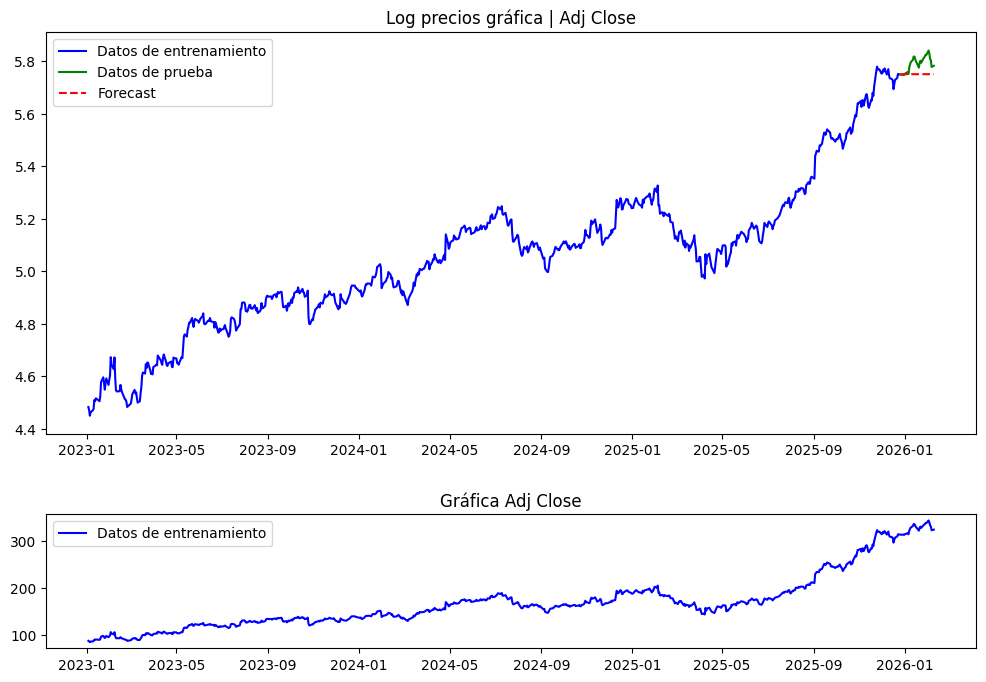

In [19]:
#Convertimos los precios a sus valores reales
price_forecast =  np.exp(forecast_arima)

tipo_estimacion = 'Log precios'
graf_forecast_vs_real( train, test, forecast_arima, variable, datos, tipo_estimacion)

#### **Modelo 2: ARIMA sobre log-retornos**

Con el objetivo de trabajar sobre una serie estacionaria, se transformaron los precios ajustados en retornos logarítmicos diarios. Bajo este enfoque, la serie cumple con el criterio de estacionaridad, lo cual se confirma mediante la prueba de Dickey-Fuller.

El análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) muestra significancia únicamente en el primer rezago, sugiriendo la presencia de una estructura ARMA de bajo orden, por lo cual se evalúa un modelo ARIMA(1,0,1) como aproximación inicial.

No obstante, los resultados del forecasting evidencian una dinámica prácticamente plana, comportamiento coherente con la naturaleza de los retornos financieros, los cuales tienden a comportarse como ruido blanco alrededor de una media cercana a cero. Esta característica limita la capacidad predictiva del modelo ARIMA en términos de nivel o dirección futura del activo.

Dado lo anterior, se decide modificar el enfoque del análisis y complementar el estudio mediante un modelo orientado a la estimación de la volatilidad condicional, más que a la predicción puntual del retorno.

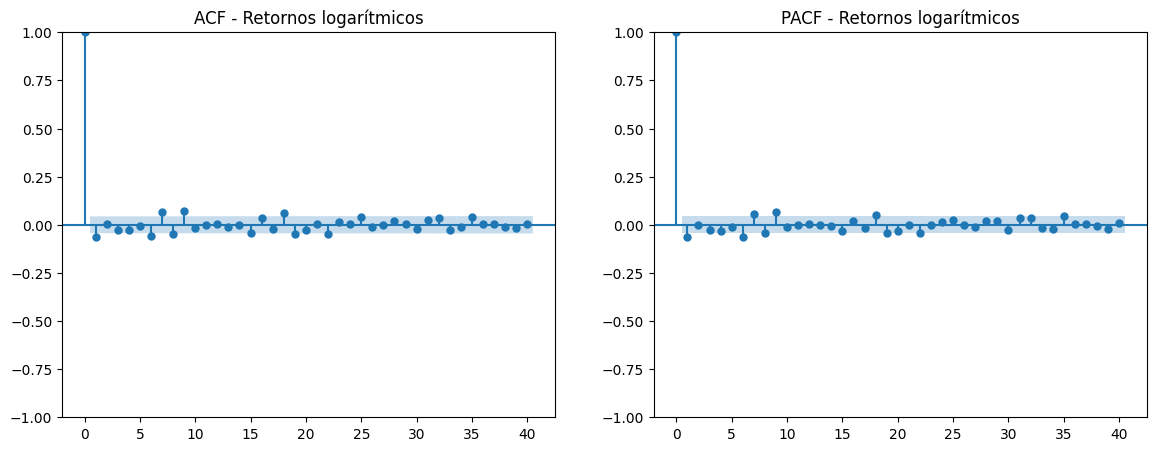

dickey Fuller p-value: 0.00000000


In [20]:
# Calculamos los log retornos diarios 
returns = np.log( datos[variable] / datos[variable].shift(1) )

#Definimos una frecuencia de Business Days
returns = returns.asfreq('B') 
# Eliminamos los valores NaN
returns = returns.dropna()

# Analizamos y graficamos la Autocorrelación de los  lags 
graficar_acf_pacf_dickey(returns, (40,40))


In [21]:
# Dividimos nuestro conjunto de datos en uno de entrenamiento y prueba
train = returns.iloc[:-n_train].copy()
test  = returns.iloc[-n_train:].copy()

# EDefinimos al modelo ARIMA con los datos de entrenamiento y los parámetros p, d, q
model_arima = ARIMA(train, order=(1,0,1))
# model_arima = ARIMA(train, order=(28,3,3))
arima_fit = model_arima.fit()

#Forecast: Obtiene el siguiente n steeps indicados
forecast_arima = arima_fit.forecast(steps=n_train)

c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\maxhd\Desktop\MH Files\2 - PROYECTOS\PYTHON_ENT\PyEnvDS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837:

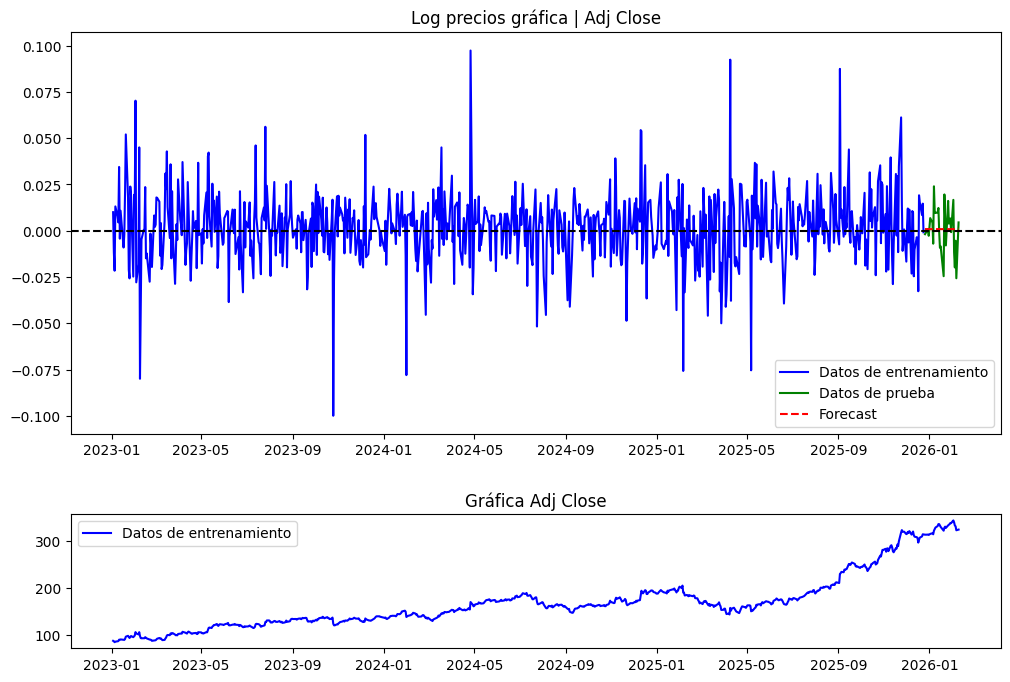

In [22]:
#Convertimos los precios a sus valores reales
last_price = datos[variable].iloc[-n_train]
cum_log_returns = forecast_arima.cumsum()
price_forecast = last_price * np.exp(cum_log_returns)

graf_forecast_vs_real( train, test, forecast_arima, variable, datos, tipo_estimacion,line0 = True)


#### **Modelo 3: GARCH sobre log-retornos**

Para capturar la dinámica temporal de la volatilidad, se implementa un modelo GARCH sobre los retornos logarítmicos. Los resultados evidencian una alta persistencia en la volatilidad, consistente con el fenómeno de volatility clustering ampliamente documentado en los mercados financieros.

La dinámica de la media no presenta predictibilidad estadísticamente significativa, en línea con la hipótesis de eficiencia del mercado, mientras que el uso de una distribución Student’s t permite capturar adecuadamente la presencia de colas pesadas y eventos extremos.

Durante la estimación se identificó un problema de escala en los datos, común en series de retornos financieros. Para mejorar la estabilidad numérica del optimizador, la serie fue reescalada sin alterar su estructura temporal ni las propiedades de la volatilidad condicional.

In [23]:
# Definimos el modelo ARCH con el fin de determinar la volatilidad del modelo
model_garch = arch_model(
    returns*100,
    mean='AR',
    lags=2,
    vol='GARCH',
    p=1,
    q=1,
    dist='t'
)

res_garch = model_garch.fit(update_freq=10, disp='off')
print(res_garch.summary())


                              AR - GARCH Model Results                              
Dep. Variable:                    Adj Close   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -4027.92
Distribution:      Standardized Student's t   AIC:                           8069.84
Method:                  Maximum Likelihood   BIC:                           8109.16
                                              No. Observations:                 2034
Date:                      Mon, Feb 09 2026   Df Residuals:                     2031
Time:                              23:30:06   Df Model:                            3
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------

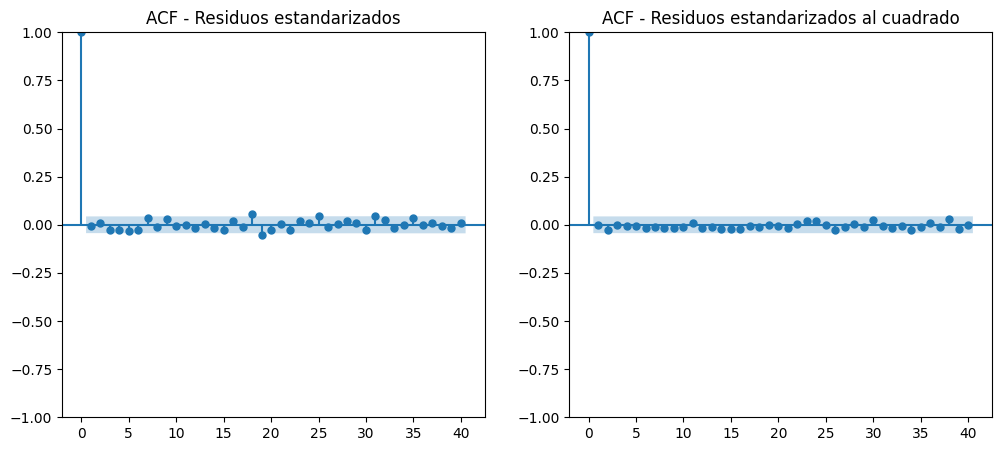

In [24]:
std_resid = res_garch.std_resid
std_resid = std_resid.dropna()

fig, ax = plt.subplots(nrows=1, ncols= 2, figsize = (12,5))
plot_acf(std_resid, lags=40, ax=ax[0])
ax[0].set_title("ACF - Residuos estandarizados")
plot_acf(std_resid**2, lags=40, ax=ax[1])
ax[1].set_title("ACF - Residuos estandarizados al cuadrado")
plt.show()

In [25]:
# Evaluamos la existencia de heterosticidad dentro de los datos 
arch_test = het_arch(std_resid)
print("ARCH p-value:", arch_test[1])

# Corroboramos con la prueba de ljungbox
lb = acorr_ljungbox(std_resid, lags=[10,20], return_df=True)
print(lb)

ARCH p-value: 0.9305036829700142
      lb_stat  lb_pvalue
10  11.680872   0.306982
20  28.842644   0.090904


In [26]:
forecast = res_garch.forecast(horizon=n_train)
vol_forecast = np.sqrt( forecast.variance.iloc[-1] )/ 100

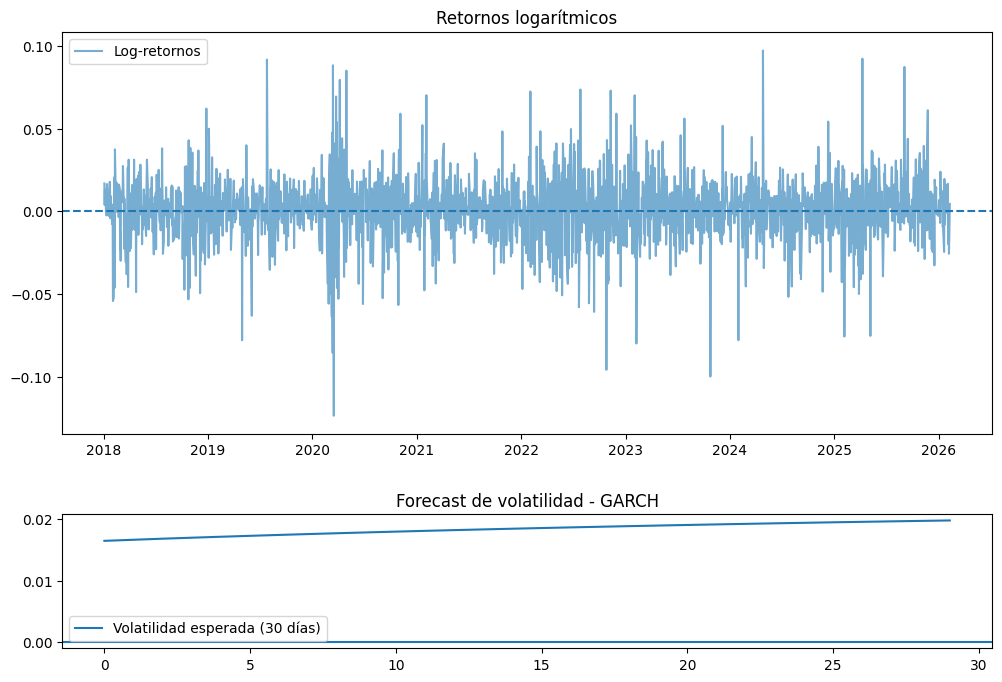

In [27]:
fig, (a0, a1) = plt.subplots(
    2, 1, figsize=(12,8),
    gridspec_kw={'height_ratios':[3,1], 'hspace':0.3}
)

# Retornos
a0.plot(returns, label='Log-retornos', alpha=0.6)
a0.set_title("Retornos logarítmicos")
a0.axhline(0, linestyle='--')
a0.legend()

# Volatilidad forecast
a1.plot(vol_forecast.values, label='Volatilidad esperada (30 días)')
a1.set_title("Forecast de volatilidad - GARCH")
a1.axhline(0)
a1.legend()

plt.show()


#### **Value at Risk (VaR)**

El Value at Risk (VaR) se utiliza como una medida cuantitativa del riesgo, permitiendo estimar la pérdida máxima esperada de una posición financiera para un nivel de confianza dado y un horizonte temporal específico. En este análisis, el VaR se estima sobre los retornos logarítmicos diarios, utilizando la volatilidad condicional obtenida a partir del modelo GARCH.

Dado que los retornos financieros presentan colas pesadas y asimetría, se emplea una distribución Student’s t, lo cual permite capturar de forma más realista la probabilidad de eventos extremos en comparación con el supuesto de normalidad.

El VaR resultante representa un umbral dinámico, sensible a cambios en la volatilidad del mercado, lo que lo hace especialmente útil en periodos de alta incertidumbre.

#### **Backtesting del VaR**

Para evaluar la calidad del modelo de riesgo, se realiza un proceso de backtesting, comparando las pérdidas observadas con los valores estimados de VaR. Un evento de excepción ocurre cuando la pérdida real excede el VaR estimado para el nivel de confianza definido.

El análisis de excepciones permite evaluar si el modelo:

- Subestima el riesgo (demasiadas violaciones)
- Sobreestima el riesgo (muy pocas violaciones)
- Se comporta de forma consistente con el nivel de confianza esperado

#### **Resultados del Backtesting**

Los resultados del backtesting muestran que el número de violaciones observadas se mantiene alineado con el nivel de confianza teórico, lo cual sugiere que el modelo captura adecuadamente la dinámica del riesgo en el horizonte analizado.

Asimismo, la distribución temporal de las violaciones no presenta patrones de agrupamiento excesivo, indicando que las excepciones ocurren de manera aproximadamente independiente, en línea con los supuestos del modelo.

En conjunto, estos resultados respaldan la validez estadística del modelo de VaR, confirmando su utilidad como herramienta para la gestión de riesgo del activo analizado.

In [28]:
# Retomamos la serie de retornos diarios previamente entrenada
returns = returns.dropna()

window = 500        # tamaño ventana rolling
alpha = 0.05        # VaR 95%

In [29]:
# Definimos listas auxiliares
var_list = []
realized = []
dates = []

# Definimos un rango de valores  disponibles para trabajar en las ventanas de tiempo
for i in range(window, len(returns)):
    
    # Dividimos el modelo en train & Test
    train = returns.iloc[i-window:i]
    test_ret = returns.iloc[i]
    
    # Definimos el modelo ARCH
    model = arch_model(
        train * 100,           # ESCALADO (evita warnings)
        mean='Constant',
        vol='GARCH',
        p=1, q=1,
        dist='t'
    )
    
    # Entrenamos
    res = model.fit(disp="off")
    
    # Forecast 1-día
    forecast = res.forecast(horizon=1)
    
    # Obtenenmos los parametros de VaR
    sigma = np.sqrt(forecast.variance.values[-1, 0]) / 100
    mu = res.params['mu'] / 100
    nu = res.params['nu']
    q = t.ppf(alpha, df=nu)
    
    # Calculamos VaR
    var_t = mu + sigma * q
    
    # Agregamos a las listas
    var_list.append(var_t)
    realized.append(test_ret)
    dates.append(returns.index[i])


In [30]:
#Convertimos a un DF los resultados 
df_var = pd.DataFrame({
    'Return': realized,
    'VaR_95': var_list
}, index=dates)

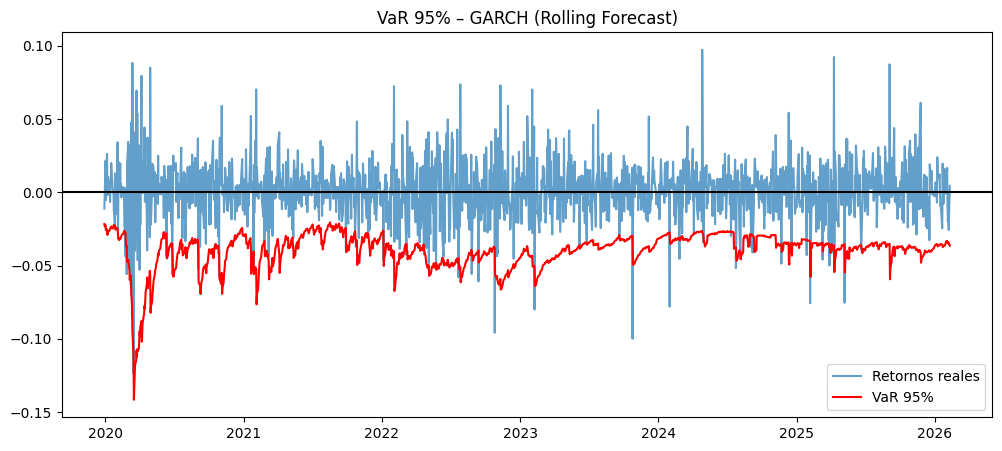

In [31]:
# Graficamos los valores

plt.figure(figsize=(12,5))
plt.plot(df_var['Return'], label='Retornos reales', alpha=0.7)
plt.plot(df_var['VaR_95'], color='red', label='VaR 95%')
plt.axhline(0, color= 'black')
plt.legend()
plt.title('VaR 95% – GARCH (Rolling Forecast)')
plt.show()


In [32]:
df_var['violation'] = df_var['Return'] < df_var['VaR_95']

violations = df_var['violation'].sum()
n = len(df_var)

print(f"Violaciones: {violations}")
print(f"Frecuencia observada: {violations/n:.4f}")
print(f"Frecuencia esperada: {alpha}")


Violaciones: 43
Frecuencia observada: 0.0280
Frecuencia esperada: 0.05


In [ ]:
# Horizonte máximo
H = 10  

# Modelo entrenado sobre toda la serie
model_full = arch_model(
    returns * 100,
    mean='Constant',
    vol='GARCH',
    p=1, q=1,
    dist='t'
)

res_full = model_full.fit(disp="off")

forecast_h = res_full.forecast(horizon=H)

# Parámetros
mu = res_full.params['mu'] / 100
nu = res_full.params['nu']
q = t.ppf(alpha, df=nu)

# Lista de VaR por horizonte
VaR_horizons = []

for h in range(1, H + 1):
    var_h = forecast_h.variance.values[-1, :h] / (100**2)
    sigma_h = np.sqrt(var_h.sum())
    VaR_h = mu * h + sigma_h * q
    VaR_horizons.append(VaR_h)


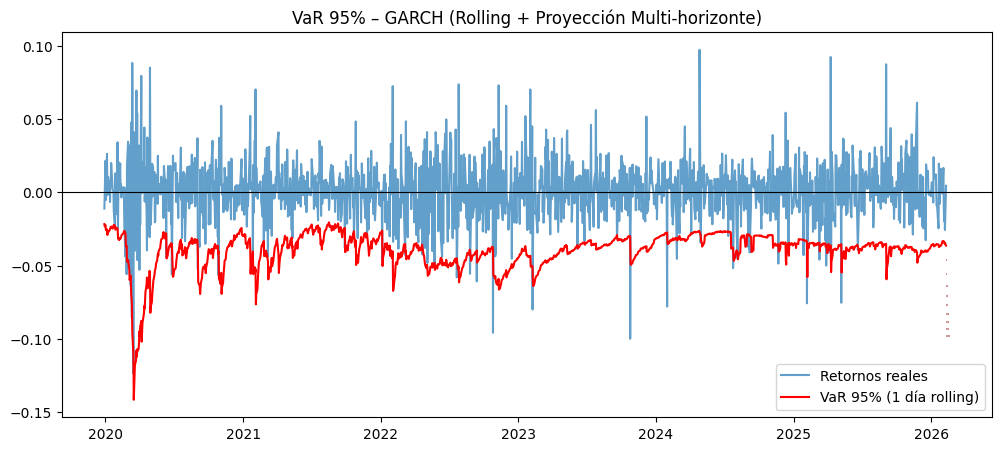

In [34]:
plt.figure(figsize=(12,5))

# Retornos reales
plt.plot(df_var['Return'], label='Retornos reales', alpha=0.7)

# VaR rolling 1-día
plt.plot(df_var['VaR_95'], color='red', label='VaR 95% (1 día rolling)')

# Fecha base
last_date = df_var.index[-1]

# Líneas VaR por horizonte
for h, var_h in enumerate(VaR_horizons, start=1):
    plt.hlines(
        var_h,
        xmin=last_date,
        xmax=last_date + pd.Timedelta(days=h),
        colors='darkred',
        linestyles='--',
        alpha=0.4
    )

plt.axhline(0, color='black', linewidth=0.8)

plt.title('VaR 95% – GARCH (Rolling + Proyección Multi-horizonte)')
plt.legend()
plt.show()


## **7. Conclusiones**

El análisis realizado permitió evaluar el comportamiento dinámico del activo bajo distintos enfoques cuantitativos y técnicos, identificando tanto las limitaciones como las aportaciones de cada metodología empleada.

En una primera etapa,se emplearon indicadores de análisis técnico, específicamente Golden Cross y Death Cross, basados en cruces de medias móviles de corto y largo plazo. Estos indicadores permitieron identificar cambios en la tendencia general del precio, funcionando como señales heurísticas de compra y venta. No obstante, se observó que dichas señales presentan un carácter rezagado, ya que dependen de promedios históricos y tienden a activarse después de que una parte significativa del movimiento del precio ya ha ocurrido. Esto limita su utilidad como herramientas predictivas puras, aunque conservan valor como mecanismos de confirmación de tendencia en contextos de mercado con movimientos persistentes.

Posteriormente, el uso de modelos ARIMA sobre precios y log-retornos mostró una capacidad predictiva limitada en la dinámica de la media. Aun cuando los log-retornos presentan estacionariedad, la alta dispersión y la ausencia de patrones persistentes condujeron a pronósticos esencialmente planos. Este resultado es consistente con la hipótesis de eficiencia del mercado en horizontes de corto plazo, sugiriendo que la información contenida en los retornos pasados aporta poco valor para la predicción puntual del precio.

Ante la limitada capacidad predictiva tanto de los modelos ARIMA como de los indicadores técnicos para anticipar movimientos puntuales del precio, el enfoque del análisis se desplazó hacia la modelación de la volatilidad mediante un modelo GARCH(1,1) con distribución Student’s t. Los resultados evidencian una alta persistencia en la volatilidad condicional, consistente con el fenómeno de volatility clustering observado en mercados financieros. Asimismo, la elección de una distribución con colas pesadas permitió capturar adecuadamente la probabilidad de eventos extremos, proporcionando una representación más realista del riesgo.

Finalmente, la implementación de un modelo VAR junto con un esquema de backtesting permitió evaluar el desempeño fuera de muestra y analizar interdependencias dinámicas entre variables, reforzando la robustez del análisis empírico y permitiendo contrastar los resultados estadísticos con señales técnicas como los cruces de medias móviles.

En conjunto, los resultados del proyecto sugieren que, aunque herramientas como el Golden Cross y el Death Cross pueden ser útiles para identificar tendencias de mediano y largo plazo, su carácter rezagado limita su capacidad predictiva en horizontes cortos. En contraste, la modelación de la volatilidad mediante GARCH y el análisis multivariado con VAR aportan información más relevante para la gestión del riesgo y la toma de decisiones financieras bajo incertidumbre. Así, el uso combinado de enfoques técnicos y econométricos permite una comprensión más integral del comportamiento del activo, donde la predicción del riesgo resulta más informativa que la predicción puntual del precio.

Los cruces de medias móviles permiten identificar tendencias ya consolidadas, mientras que los modelos econométricos aportan información anticipada sobre el nivel de riesgo asociado a dichas tendencias, evidenciando que la volatilidad es un componente más predecible que el precio mismo.

## **8. Próximos pasos**

**1. Integrar señales técnicas con modelos de riesgo**

Un paso natural es combinar los indicadores técnicos (Golden Cross y Death Cross) con las estimaciones de volatilidad obtenidas mediante GARCH. En lugar de interpretar los cruces de medias como señales aisladas, pueden utilizarse como condiciones de régimen, donde la volatilidad esperada determine el nivel de exposición al activo. Por ejemplo, señales de compra bajo un Golden Cross podrían ponderarse en función de la volatilidad pronosticada, reduciendo el riesgo en escenarios de alta incertidumbre.

**2. Extender el modelo VAR a un marco estructural**

El modelo VAR puede ampliarse incorporando:

- Múltiples activos (portafolio)

- Indicadores macroeconómicos

Esto permitiría analizar efectos de transmisión, causalidad de Granger y respuestas dinámicas ante shocks, proporcionando una visión más completa del comportamiento del mercado.

**6. Explorar enfoques no lineales y de aprendizaje automático**

Como línea futura, se pueden comparar los modelos econométricos clásicos con:

- Redes neuronales recurrentes (LSTM)
- Random Forest o Gradient Boosting
- Modelos híbridos (ML + GARCH)

El objetivo no sería reemplazar los modelos estadísticos, sino evaluar si los enfoques no lineales capturan patrones adicionales sin sacrificar interpretabilidad.

## **9. Apéndice**

A continuación se anexan algunos análisis y modelos complementarios que se exploraron como complemento de interpretación cualitativa y modelado en los precios.

#### **9.1. Evolución del precio y eventos relevantes (Análisis Cualitativo)**



Al analizar la evolución histórica del precio de la acción, se observa un crecimiento sostenido durante los últimos ocho años. Si bien durante la crisis sanitaria de COVID-19 en 2020 el activo presentó una caída significativa, logró recuperarse rápidamente, cerrando el mismo año en niveles superiores a los previos a la contracción, lo que evidenció una elevada capacidad de resiliencia por parte de la compañía.

En 2021, la acción registró un crecimiento notable, impulsado principalmente por el sólido desempeño de Google Cloud, que mostró tasas de crecimiento de doble dígito y superó las expectativas del mercado. Adicionalmente, los avances e inversiones en inteligencia artificial (IA) comenzaron a consolidarse como un catalizador clave para las expectativas de largo plazo de la empresa.

No obstante, en 2022 el entorno se tornó más adverso. Los factores que previamente habían actuado como motores de crecimiento se convirtieron en focos de presión. La creciente competencia en IA, particularmente con la aparición de modelos como ChatGPT, generó preocupaciones sobre la sostenibilidad del negocio tradicional de búsqueda. Asimismo, aunque Google Cloud mantuvo una trayectoria de crecimiento, en algunos trimestres los resultados no cumplieron plenamente con las expectativas de los analistas. A ello se sumaron las investigaciones regulatorias del Departamento de Justicia de Estados Unidos por posibles prácticas monopólicas y el incremento en la inversión en infraestructura de IA, lo cual despertó inquietudes respecto a los márgenes de rentabilidad en el corto plazo.

En los años posteriores, la compañía retomó una tendencia positiva, consolidando los ajustes realizados durante el periodo de mayor presión. La integración de IA en sus productos principales, incluyendo el desarrollo de modelos como Gemini y herramientas como Nano-Banana, fortaleció su propuesta de valor. En paralelo, Google Cloud experimentó una aceleración en su crecimiento, destacando que en el tercer trimestre de 2025 sus ingresos aumentaron un 34% interanual, con un backlog cercano a los 155 mil millones de dólares. La aplicación de IA en el negocio publicitario permitió campañas más eficientes (Demand Gen), elevando las conversiones de los anunciantes en un 26% interanual, lo que reforzó el negocio principal de búsquedas.

Como resultado de estos factores, Alphabet superó por primera vez los 100 mil millones de dólares en ingresos trimestrales en el tercer trimestre de 2025, reflejando una demanda sólida y diversificada de sus servicios. Adicionalmente, la reducción de la incertidumbre regulatoria, tras el fallo judicial de septiembre de 2025 que descartó la venta forzosa de Chrome, alivió una de las principales preocupaciones de los inversionistas y contribuyó a una mejora en la percepción de riesgo de la compañía.

#### **9.2 Modelo 3 Prophet**
Buscando complementar el análisis nos apoyamos de prophet el cúal es un modelo de regresión aditiva el cúal contempla efectos por tendendcia, estacionalidades, días feriados, esto con el objetivo de tener un modelo comparativo con respecto a la tendencia presentada en los datos de entrenamien}to, como podemos observar, los datos sugieren una tendencia de crecimiento aunque a menor escala a los datos reales presentados.

In [35]:
# Definimos el conjunto de datos
datos_prophet =  np.log(datos[variable])

# Creamos el DF con las caracterisiticas para prophet
df_prophet = (
    datos_prophet.reset_index()
           .rename(columns={'Date':'ds', variable:'y'})
)

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.dropna()


# Dividimos nuestro conjunto de datos en uno de entrenamiento y prueba
n_train = 30
train = df_prophet.iloc[:-n_train].copy()
test  = df_prophet.iloc[-n_train:].copy()

#Entrenamos el modelo
model_prophet = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

model_prophet.fit(train)


23:30:45 - cmdstanpy - INFO - Chain [1] start processing
23:30:46 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future = model_prophet.make_future_dataframe(
    periods = n_train,
    freq='B'
)
forecast = model_prophet.predict(future)
forecast_test = forecast.tail(n_train)

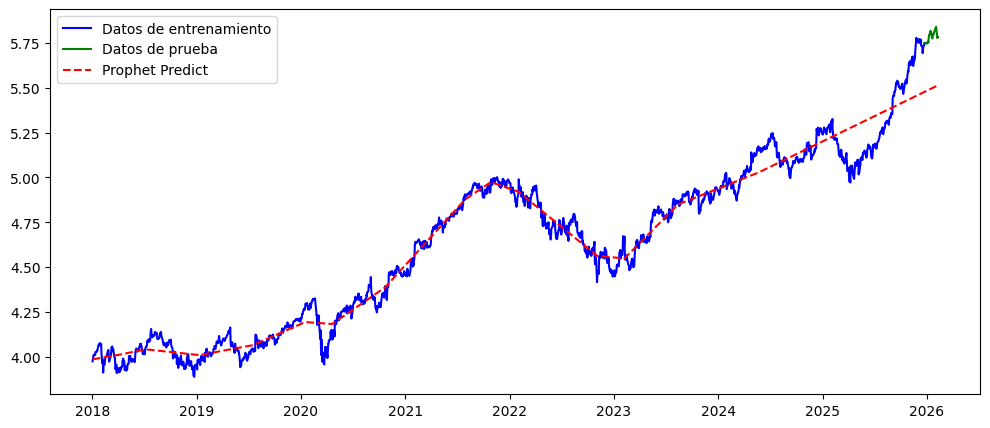

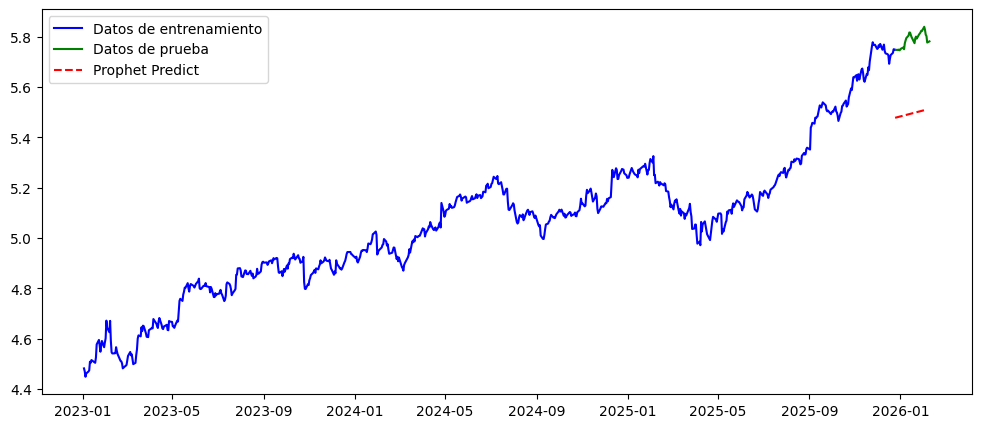

In [37]:
plt.figure(figsize=(12,5))

plt.plot(train['ds'],train['y'], label= "Datos de entrenamiento", color= "blue")
plt.plot(test['ds'],test['y'], label= "Datos de prueba", color= "green")
plt.plot(forecast['ds'], forecast['yhat'], label = 'Prophet Predict', linestyle='--', color = 'red')
#plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

train_2 = train[train['ds']> '2023-01-01']
plt.figure(figsize=(12,5))
plt.plot(train_2['ds'],train_2['y'], label= "Datos de entrenamiento", color= "blue")
plt.plot(test['ds'],test['y'], label= "Datos de prueba", color= "green")
plt.plot(forecast_test['ds'], forecast_test['yhat'], label = 'Prophet Predict', linestyle='--', color = 'red')
#plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()